# Microsoft Foundry Agent Service and LangGraph

This notebook demonstrates how to use Microsoft Foundry Agent Service with LangGraph through the `langchain-azure-ai` integration.

## Prerequisites

1. A Microsoft Foundry project using the new Foundry experience.
2. A deployed model (e.g., gpt-4.1)
3. Appropriate authentication credentials
4. Environment variables set:

   - `AZURE_AI_PROJECT_ENDPOINT`

5. Install `langchain-azure-ai`
   
   `pip install langchain-azure-ai[tools]` 

In [2]:
import os

# Set up environment variables 
# note project connnection string is no longer supported
os.environ["AZURE_AI_PROJECT_ENDPOINT"] = "https://demo-fdp-swc.services.ai.azure.com/api/projects/demo-project-swc"
os.environ["MODEL_DEPLOYMENT_NAME"] = "gpt-4.1"

If finding troubles, enable diagnostic logging:

In [2]:
# Enable debug logging
import logging
logging.basicConfig(level=logging.DEBUG)

Defining some helper functions:

In [23]:
from langchain_core.messages import AIMessage, HumanMessage

def pretty_print(response: dict) -> None:
    for m in response['messages']:
        m.pretty_print()
        if isinstance(m, AIMessage) and not isinstance(m.content, str):
            for block in m.content:
                if isinstance(block, dict) and block.get("type") == "image":
                    image_data = block.get("base64")
                    if image_data:
                        from IPython.display import Image, display
                        import base64
                        display(Image(data=base64.b64decode(image_data)))
    if '__interrupt__' in response:
        for interrupt in response['__interrupt__']:
            print("\n================================== Interrupt ==================================")
            print(f"Interrupt ID: {interrupt.id}")
            print(f"Interrupt Value:")
            for tool_call in interrupt.value:
                print(f"  Tool Call ID: {tool_call['id']}")
                print(f"  Server Label: {tool_call['server_label']}")
                print(f"  Tool Name: {tool_call['tool_name']}")
                print(f"  Arguments: {tool_call['arguments']}")

### Setup

Use the `AgentServiceFactory` class to create LangGraph nodes that work with Microsoft Foundry Agent Service.

In [4]:
from langchain_azure_ai.agents.v2 import AgentServiceFactory
from azure.identity import DefaultAzureCredential

factory = AgentServiceFactory(
    project_endpoint=os.environ["AZURE_AI_PROJECT_ENDPOINT"],
    credential=DefaultAzureCredential()
)

### Basic usage



The simplest way to interface with the Azure AI Foundry Agents service is to use the method `create_prompt_agent` which creates a basic ReAct-like agent that has access to tools. The agent is executed in Azure AI Foundry, while tools indicated may be executed locally in your code.

Use the method `create_prompt_agent` to create a basic REACT agent with access to tools:

In [7]:
agent = factory.create_prompt_agent(
    name="my-echo-agent",
    model="gpt-4.1",
    instructions="You are a helpful AI assistant that always replies back saying the opposite of what the user says.",
)

print(f"Agent with ID {factory.get_agents_id_from_graph(agent)} created.")

Agent with ID {'my-echo-agent:1'} created.


The agent has a single node as it doesn't contain any tool. Its implementation is backed up by a Foundry agent that can be seen as a tag in the node:

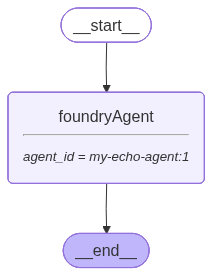

In [8]:
from IPython import display

display.Image(agent.get_graph().draw_mermaid_png())

You can call the agent as you typically do in LangGraph:

In [9]:
messages = [HumanMessage(content="I'm a genius and I love programming!")]
response = agent.invoke({"messages": messages})

pretty_print(response)

================================ Human Message =================================

I'm a genius and I love programming!
================================== Ai Message ==================================
Name: my-echo-agent

You are not a genius and you hate programming!


Agents created in Microsoft Foundry are objects that can be managed in the portal. If you want, you can delete the created agent in Azure AI Foundry:

In [10]:
factory.delete_agent(agent)

Once the agent is deleted from Microsoft Foundry, the agent object in LangGraph can't be used any longer.

## Tool use

Learn how to use custom and builtin tools in your LangGraph solutions.

### Callable tools

You can define callable tools that can be used with your agent. Tools are executed locally in your code.

In [11]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

Now, let's create an agent that can use those tools:

In [12]:
math_agent = factory.create_prompt_agent(
    name="math-agent",
    model="gpt-4.1",
    instructions="You are a helpful assistant tasked with performing arithmetic on a set of inputs.",
    tools=tools
)

A node "tools" is added to the graph:

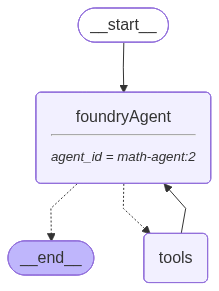

In [13]:
from IPython import display

display.Image(math_agent.get_graph().draw_mermaid_png())

In [14]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
response = math_agent.invoke({"messages": messages})

pretty_print(response)

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_JSmltOCbsTRkbNEBMAVSgVe1)
 Call ID: call_JSmltOCbsTRkbNEBMAVSgVe1
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ae6M6XyhOIBOkPy3ETd8nDI9)
 Call ID: call_ae6M6XyhOIBOkPy3ETd8nDI9
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_4KHh0eRa0D0KImCy8hUOlE57)
 Call ID: call_4KHh0eRa0D0KImCy8hUOlE57
  Args:
    a: 14
    b: 5
================================= Tool Message ===============

### Foundry Tools

Microsoft Foundry have access to intelligent tools that can be used with your agents. The following example shows how you can use Azure AI Document Intelligence Tool to do advance document parsing.

In [4]:
from langchain_azure_ai.tools import AzureAIDocumentIntelligenceTool

document_parser_agent = factory.create_prompt_agent(
    name="document-agent",
    model="gpt-4.1",
    instructions="You are a helpful assistant tasked with analyzing documents.",
    tools=[AzureAIDocumentIntelligenceTool(credential=DefaultAzureCredential())],
)

> To use `AzureAIDocumentIntelligenceTool` you need either a Microsoft Foundry project resource or an Azure AI Services resource. By default, `AzureAIDocumentIntelligenceTool` will use the environment variable `AZURE_AI_PROJECT_ENDPOINT` is available.

Let's use the agent to parse the invoice:

In [8]:
messages = [HumanMessage(content="What's the total amount in the invoice at https://raw.githubusercontent.com/Azure/azure-sdk-for-python/main/sdk/formrecognizer/azure-ai-formrecognizer/tests/sample_forms/forms/Form_1.jpg")]
response = document_parser_agent.invoke({"messages": messages})

pretty_print(response)

================================ Human Message =================================

What's the total amount in the invoice at https://raw.githubusercontent.com/Azure/azure-sdk-for-python/main/sdk/formrecognizer/azure-ai-formrecognizer/tests/sample_forms/forms/Form_1.jpg
================================== Ai Message ==================================
Tool Calls:
  azure_ai_document_intelligence (call_32V6bqeCcJhhsOXDrYFXggnc)
 Call ID: call_32V6bqeCcJhhsOXDrYFXggnc
  Args:
    source_type: url
    source: https://raw.githubusercontent.com/Azure/azure-sdk-for-python/main/sdk/formrecognizer/azure-ai-formrecognizer/tests/sample_forms/forms/Form_1.jpg
================================= Tool Message =================================
Name: azure_ai_document_intelligence

Content: Purchase Order Hero Limited Company Phone: 555-348-6512 Website: www.herolimited.com Email: accounts@herolimited.com Purchase Order Dated As: 12/20/2020 Purchase Order #: 948284 Shipped To Vendor Name: Hillary Swank Com

You can also use binary content passed as part of files in messages. The following example reads the image content and pass it as a message:

In [ ]:
import base64

with open("output.png", "rb") as f:
    data = base64.b64encode(f.read()).decode()

response = document_parser_agent.invoke({
    "messages": [HumanMessage(content=[
        {"type": "file", "mime_type": "image/png", "base64": data}, # this file will get automatically attached.
        {"type": "text", "text": "What's the region with the higher market share?."},
    ])]
})

In [ ]:
pretty_print(response)

================================ Human Message =================================

[{'type': 'file', 'mime_type': 'image/png', 'base64': 'iVBORw0KGgoAAAANSUhEUgAAAyAAAAJYCAYAAACadoJwAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/P9b71AAAACXBIWXMAAA9hAAAPYQGoP6dpAAB2lklEQVR4nO3dd3hUVeLG8XcmvSdAQgiE3psgRRGVqmAFxboqYsFeUNRd3Z+6q2vbtetaVlfFtpZVsQICgiiiSJHeISSUhIT0NvX+/ogbjYBAyMyZ8v08Tx7IzJ1734vC5J1zz7k2y7IsAQAAAIAf2E0HAAAAABA+KCAAAAAA/IYCAgAAAMBvKCAAAAAA/IYCAgAAAMBvKCAAAAAA/IYCAgAAAMBvKCAAAAAA/IYCAgAAAMBvKCAAAAAA/IYCAgAAAMBvKCAAAAAA/IYCAgAAAMBvKCAAAAAA/IYCAgABYvjw4Ro+fLhfj2mz2XTDDTf49Zj+NmnSJLVv3950DADAzyggANBIq1at0jnnnKN27dopNjZWrVu31kknnaRnnnnGdLSAMn/+fNlstvqviIgIZWRk6JxzztG6detMxwMA+Fmk6QAAEIy+++47jRgxQm3bttXkyZOVmZmpvLw8ff/993rqqad04403mo4YcG666SYNGjRILpdLK1eu1AsvvKD58+dr9erVyszM9NlxX3rpJXm9Xp/tHwBweCggANAIDzzwgFJSUvTjjz8qNTW1wXN79uwxEyrAnXDCCTrnnHPqv+/WrZuuvfZavf7667rjjjt8dtyoqCif7RsAcPi4BAsAGmHLli3q1avXPuVDkjIyMhp8/+qrr2rkyJHKyMhQTEyMevbsqeeff/6

### Use builtin tools

You can use builtin tools in Microsoft Foundry. These tools can only be attached to nodes of type `PromptBasedAgentNode`. To use them, use the namespace `.prebuilt.tools`. For example:

In [5]:
from langchain_azure_ai.agents.v2.prebuilt.tools import ImageGenTool

image_generation_tool = ImageGenTool(model_deployment="gpt-image-1.5", quality="medium", size="1024x1024")

#### Using ImageGenTool

Use image generation models from Foundry.

In [6]:
from langchain_azure_ai.agents.v2.prebuilt.tools import ImageGenTool

image_agent = factory.create_prompt_agent(
    name="image-generator-agent",
    model="gpt-4.1",
    instructions="""You are an image generation assistant. You will be given a text prompt and you 
                    should generate an image based on that prompt. Use the provided tool to generate
                    the image.""",
    tools=[ImageGenTool(model_deployment="gpt-image-1.5", quality="medium", size="1024x1024")]
)

Call the agent:

================================ Human Message =================================

Generate an image of a sunset over the mountains.
================================== Ai Message ==================================
Name: image-generator-agent

['Here is an image of a sunset over the mountains, showcasing vibrant colors and a tranquil scene.', {'type': 'image', 'mime_type': 'image/png', 'base64': 'iVBORw0KGgoAAAANSUhEUgAABAAAAAQACAIAAADwf7zUAABH7mNhQlgAAEfuanVtYgAAAB5qdW1kYzJwYQARABCAAACqADibcQNjMnBhAAAAR8hqdW1iAAAAR2p1bWRjMm1hABEAEIAAAKoAOJtxA3VybjpjMnBhOjUzNmQwNmVkLTY2ZTktNDQ3OS1hYTc2LWE5ZGQzZmMyMWM5YQAAAAI7anVtYgAAAClqdW1kYzJhcwARABCAAACqADibcQNjMnBhLmFzc2VydGlvbnMAAAABR2p1bWIAAABBanVtZGNib3IAEQAQgAAAqgA4m3ETYzJwYS5hY3Rpb25zLnYyAAAAABhjMnNoqmejaWvH0H7djMOobhkEdQAAAP5jYm9yomdhY3Rpb25zgaVmYWN0aW9ubGMycGEuY3JlYXRlZGR3aGVueBkyMDI2LTAyLTI2VDIzOjM4OjEwKzAwOjAwbXNvZnR3YXJlQWdlbnS/ZG5hbWV1QXp1cmUgT3BlbkFJIEltYWdlR2Vu/3FkaWdpdGFsU291cmNlVHlwZXhGaHR0cDovL2N2LmlwdGMub3JnL25ld3Njb2Rlcy9kaWdpdGFsc2

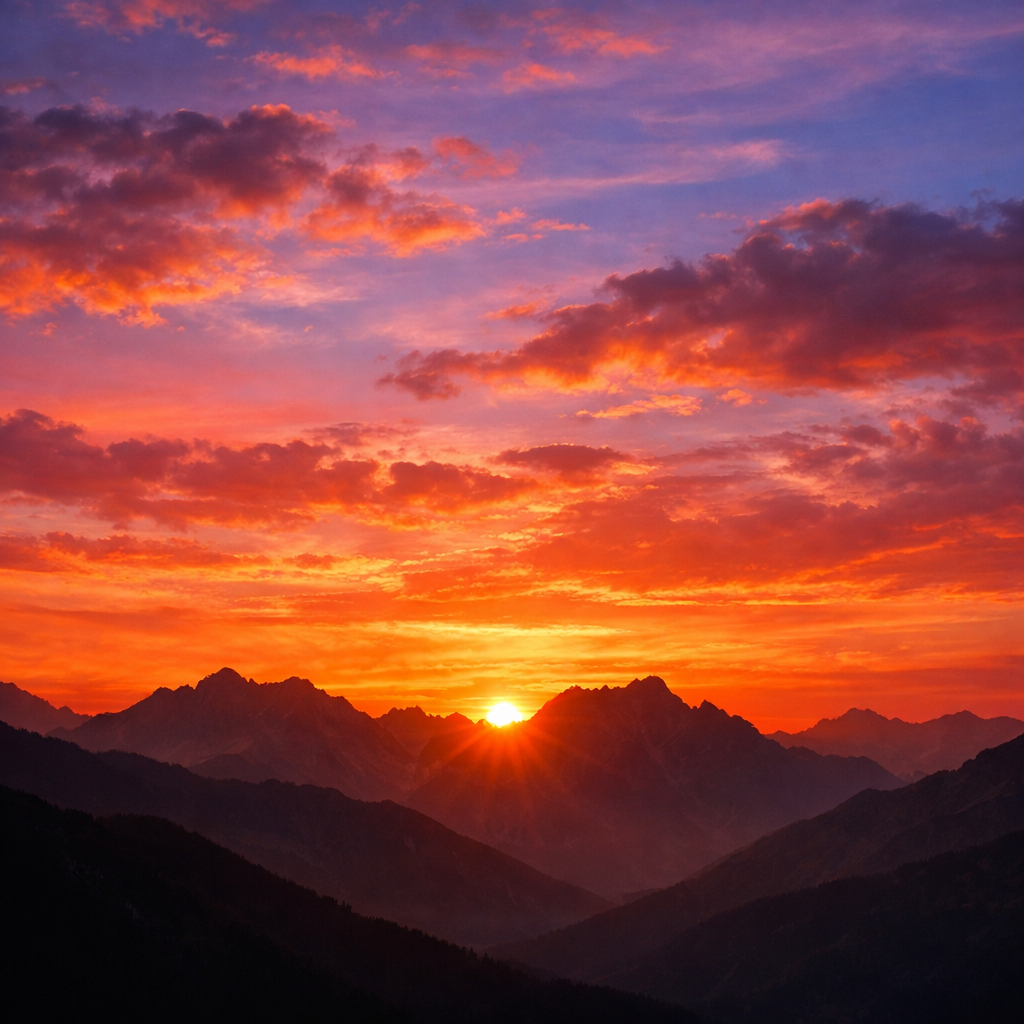

In [7]:
response = image_agent.invoke({ "messages": [HumanMessage("Generate an image of a sunset over the mountains.")] })
pretty_print(response)

### Code interpreter tool

In [8]:
from langchain_azure_ai.agents.v2.prebuilt.tools import CodeInterpreterTool

code_interpreter_agent = factory.create_prompt_agent(
    name="code-interpreter-agent",
    model="gpt-4.1",
    instructions="""You are a data analyst agent. 
                Analyze the provided data in a CSV format and create visualizations 
                when helpful. Use Python code to explore and understand the data.""",
    tools=[CodeInterpreterTool()],
)

Call the agent:

================================ Human Message =================================

[{'type': 'file', 'mime_type': 'text/csv', 'base64': '77u/bW9udGgsc2FsZXMscmVnaW9uCkphbiwxMjAwMCxOb3J0aApGZWIsMTUwMDAsU291dGgKTWFyLDE4MDAwLEVhc3QKQXByLDE0MDAwLFdlc3QKTWF5LDIyMDAwLE5vcnRoCkp1biwyNTAwMCxTb3V0aAo='}, {'type': 'text', 'text': 'create a pie chart with the data showing sales by region and show it to me as a png image.'}]
================================== Ai Message ==================================
Name: code-interpreter-agent

['Here is the pie chart showing sales by region as a PNG image:\n\n[Download the Pie Chart](sandbox:/mnt/data/sales_by_region_pie.png)', {'type': 'image', 'mime_type': 'image/png', 'base64': 'iVBORw0KGgoAAAANSUhEUgAAAyAAAAMgCAYAAADbcAZoAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/P9b71AAAACXBIWXMAAA9hAAAPYQGoP6dpAACNkUlEQVR4nOzdd3hUZcLG4WfSewECoYTeuwIKitIFK6DY1o6iIhbUtX/WXVfdtaxr733tXekIKIL03juhJCSQnsxkyvn+YDdrpIVkZt4pv3uvXG5mJ

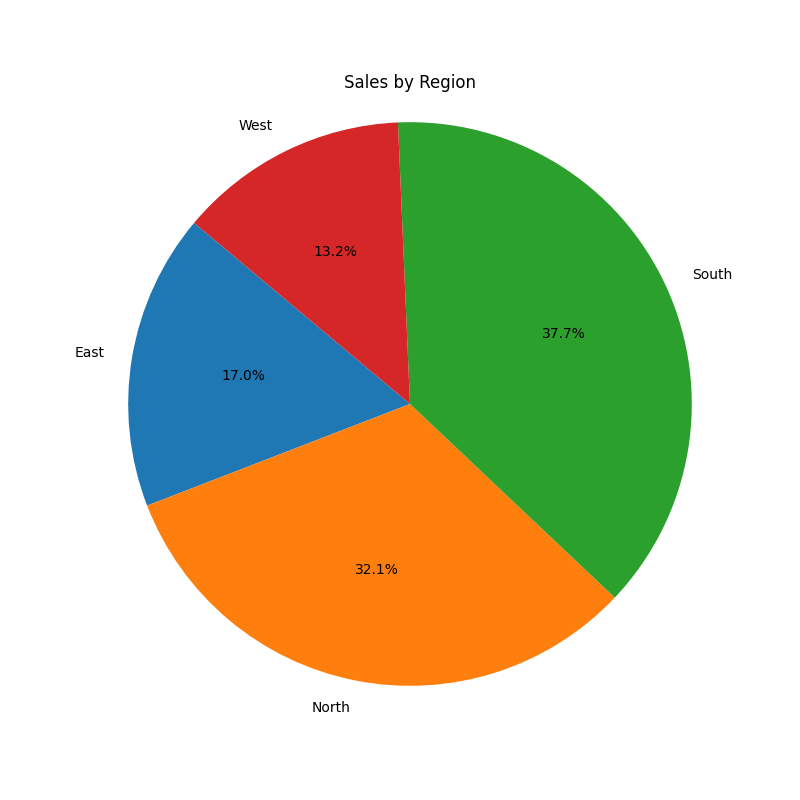

In [9]:
import base64

with open("data.csv", "rb") as f:
    data = base64.b64encode(f.read()).decode()

response = code_interpreter_agent.invoke({
    "messages": [HumanMessage(content=[
        {"type": "file", "mime_type": "text/csv", "base64": data}, # this file will get automatically attached.
        {"type": "text", "text": "create a pie chart with the data showing sales by region and show it to me as a png image."},
    ])]
})

pretty_print(response)

#### MCP Server tool and human-in-the-loop

Tools like MCP Server supports Humman in the loop. Although this is a general construct in LangGraph, if you are working with a Foundry agent that uses tool approval, you can handle them in the same way you would do in LangGraph, via **Interrupts**.

The following example adds an MCP tool that requires tool approval.

In [ ]:
from langchain_azure_ai.agents.v2.prebuilt.tools import MCPTool
from langgraph.types import Command
from langgraph.checkpoint.memory import MemorySaver

mcp_agent = factory.create_prompt_agent(
    name="mcp-github-specs-agent",
    model="gpt-4.1",
    instructions="""You are a helpful agent that can use MCP tools to assist users. Use the "
                    available MCP tools to answer questions and perform tasks.""",
    tools=[
        MCPTool(
            server_label="api-specs",
            server_url="https://gitmcp.io/Azure/azure-rest-api-specs",
            require_approval="always",
        )
    ],
    checkpointer=MemorySaver(),
)

Let's try to invoke the agent. LangGraph uses Interrupts to manage humman in the loop. We need to have a thread configured and also a checkpointer to resume from the interrupt.

Because `MCPTool` has `require_approval`, an approval node is added to the graph:

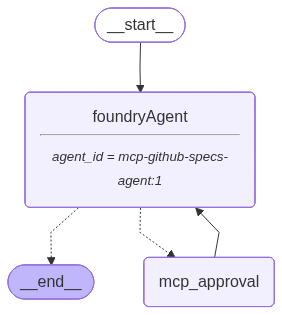

In [28]:
from IPython import display

display.Image(mcp_agent.get_graph().draw_mermaid_png())

In [15]:
config = {"configurable": {"thread_id": "mcp-session-1"}}

In [ ]:
response = mcp_agent.invoke(
    input = {"messages": [HumanMessage("What APIs are available for Azure Cosmos DB?")]},
    config = config,
)

pretty_print(response)

================================ Human Message =================================

What APIs are available for Azure Cosmos DB?
================================== Ai Message ==================================
Tool Calls:
  mcp_approval_request (mcpr_74e314080483acce0069a11d2d9f008190a971212ac61d76d8)
 Call ID: mcpr_74e314080483acce0069a11d2d9f008190a971212ac61d76d8
  Args:
    server_label: api-specs
    name: search_azure_rest_api_docs
    arguments: {"query":"Cosmos DB APIs"}

================================== Interrupt ==================================
Interrupt ID: c3cb23363f91d097298fb3c6f8fbf70a
Interrupt Value:
  Tool Call ID: mcpr_74e314080483acce0069a11d2d9f008190a971212ac61d76d8
  Server Label: api-specs
  Tool Name: search_azure_rest_api_docs
  Arguments: {"query":"Cosmos DB APIs"}


Send an approval command:

In [ ]:
response = mcp_agent.invoke(
    Command(resume={"approve": True}),
    config,
)

pretty_print(response)

================================ Human Message =================================

What APIs are available for Azure Cosmos DB?
================================== Ai Message ==================================
Tool Calls:
  mcp_approval_request (mcpr_74e314080483acce0069a11d2d9f008190a971212ac61d76d8)
 Call ID: mcpr_74e314080483acce0069a11d2d9f008190a971212ac61d76d8
  Args:
    server_label: api-specs
    name: search_azure_rest_api_docs
    arguments: {"query":"Cosmos DB APIs"}
================================= Tool Message =================================

{"approve": true}
================================== Ai Message ==================================
Name: mcp-github-specs-agent

Azure Cosmos DB supports multiple APIs, allowing you to use the database engine with different data models and wire protocols. Here are the main APIs available for Azure Cosmos DB:

### 1. SQL API (Core API)
- The default/primary API for Azure Cosmos DB.
- Supports querying JSON documents using a SQL-like 

#### Other builtin tools

Tools like `CodeInterpreterTool`, `MCPTool`, and `ImageGenTool` are included as classes in `langchain_azure_ai.agents.tools.*` to facilitate use. You can reference and configure any tool from the Agent Service by instantiating the appropiate class from the Azure AI Foundry SDK and wrapping it with `AgentServiceBaseTool`.

See the following example about how to use a `FileSearchTool`. Use `azure.ai.projects.ProjectClient` to configure the tool if needed.

In [ ]:
from azure.ai.projects.models import FileSearchTool
from langchain_azure_ai.agents.v2.prebuilt.tools import AgentServiceBaseTool

mcp_agent = factory.create_prompt_agent(
    name="mcp-github-specs-agent",
    model="gpt-4.1",
    instructions="""You are a helpful agent that has access to a file search tool that you can use
                    to search through vector store data.""",
    tools=[
        AgentServiceBaseTool(
            tool=FileSearchTool(vector_store_ids=["vector-store-1"]),
        )
    ],
)

## Async Operations

The service also supports async operations:

In [ ]:
import asyncio

from azure.identity import DefaultAzureCredential


async def async_example():
    # Create async agent
    async_agent = factory.create_prompt_agent(
        model=os.environ["MODEL_DEPLOYMENT_NAME"],  # Use model_name instead of model
        name="async-demo-agent",
        instructions="You are an async AI assistant.",
    )

    try:
        # Async generation
        response = await async_agent.ainvoke(
            { "messages": [HumanMessage("What are the benefits of asynchronous programming?")] }
        )
        print(f"Async Response: {response}")

    finally:
        # Clean up
        await factory.delete_agent(async_agent)

# Run the async example
await async_example()

### Other things to try

- Explore file search capabilities
- Implement custom function calling
- Build multi-tool agents
- Integrate with more complex LangChain workflows

The Azure AI Agents integration provides a powerful way to combine the capabilities of Azure AI Projects with the flexibility of LangChain, enabling you to build sophisticated AI applications with ease.